In [ ]:
#############################################################
# Compile `main.cu` to `file.exe`
# Commented out because we don't want to run it all the time
#############################################################
!nvcc -w functions.cu main.cu -o file

In [1]:
#############################################################
# Load python dependencies
# If package cannot be resolved from pylance, reload the interpreter
#############################################################
import numpy as np
import matplotlib.pyplot as plt
import utils

# Generate detuning
todo: distribution functions
read into detuning.dat

In [ ]:
#############################################################
# Generate and write detuning data to file
#############################################################
# Write 1D numpy array to file
detuning_values_1d = utils.gen_same_pop(2, 1000, None)
print("Detuning data:", detuning_values_1d)
np.savetxt("Detuning.dat", detuning_values_1d, delimiter="\t")

# Example: write 2D numpy array to file
# values_2d = np.array([
#     [10.0, 20.0, 40.0],
#     [10.0, 20.0, 50.0],
#     [10.0, 20.0, 60.0]
# ])
# np.savetxt("values_2d.dat", values_2d, delimiter="\t")

# Run simulation

To run a single system, use terminal: 

         k  n_tot theta,phi g gamma chi kap t_end t_num handle

file.exe 20 100000 0.5 0.0 1.6 0.0 0.0 160 0.5 600000 k20N5_0.5_0_kappa160

## Suggested file naming convention:
k{num_ens}N{order of magnitude of n_total}_{theta_phi}_{other params}

E.g., k5N5_1_0_kappa160

The below block of code is useful for running multiple jobs

In [ ]:
num_ens_range = [2]
max_det_range = [0,100,1000,5000]
det_range_manual = []
sym_range = [False]
N_total_range = [10000]
theta_0_range = [1]
phi_0_range = [0.0]
coup_a_0_range = [1.0]
gamma_a_0_range = [0.0]
chi_a_0_range = [0.0]
kappa_c_0_range = [100.0]
t_max_range = [0.2]
t_num_range = [60000]
det_dict = {}
handle_list = []

runs = 0
for num_ens in num_ens_range:
    for max_det in max_det_range:
        for sym in sym_range:
            detuning_values_1d = utils.gen_same_pop(num_ens, max_det, sym)
            FWHM = detuning_values_1d[int(num_ens/2)]
            np.savetxt(f"Detuning.dat", detuning_values_1d, delimiter="\t")
            for N_total in N_total_range:
                for theta_0 in theta_0_range:
                    for phi_0 in phi_0_range:
                        for coup_a_0 in coup_a_0_range:
                            for gamma_a_0 in gamma_a_0_range:
                                for chi_a_0 in chi_a_0_range:
                                    for kappa_c_0 in kappa_c_0_range:
                                        for t_max in t_max_range:
                                            for t_num in t_num_range:
                                                runs += 1
                                                params = f'{num_ens} {N_total} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
                                                handle = f'k{num_ens}N{N_total}det{max_det}_{theta_0}_{phi_0}_{sym}_{runs}' # Add extra notes as needed
                                                det_dict[handle] = detuning_values_1d
                                                handle_list.append(handle)
                                                print(f"************************* Run {runs} *************************")
                                                print(f"FWHM: {FWHM}, handle: {handle} ")
                                                utils.runcmd(f'file.exe {params} {handle}')
                                                print("\n")

In [3]:
#############################################################
# Test 2: effect of inhomogeneous broadening (intermediate case)
#############################################################
max_det = 280
detunings = [[0,max_det],[0,max_det/2],[0,max_det/2,max_det],
             [0,max_det/3], [0,max_det/3, max_det], 
             [0, 2*max_det/3], [0, 2*max_det/3, max_det]]
num_ens = 3
N_ens = 5000
theta_0 = 1
phi_0 = 0.0
coup_a_0 = 1.0
gamma_a_0 = 0.0
chi_a_0 = 0.0
kappa_c_0 = 100.0
t_max = 0.2
t_num = 60000
run = 0
det_dict = {}
handle_list = []

for i in range(len(detunings)):
    np.savetxt(f"Detuning.dat", detunings[i], delimiter="\t")
    num_ens = len(detunings[i])
    params = f'{num_ens} {N_ens*num_ens} {theta_0} {phi_0} {coup_a_0} {gamma_a_0} {chi_a_0} {kappa_c_0} {t_max} {t_num}'
    handle = f'k{num_ens}N{N_ens*num_ens}det{max_det}_{theta_0}_{coup_a_0}_{kappa_c_0}_{i+1}' # Add extra notes as needed
    det_dict[handle] = detunings[i]
    handle_list.append(handle)
    print(f"************************* Run {i+1} *************************")
    print(f"Handle: {handle} ")
    utils.runcmd(f'file.exe {params} {handle}')
    print("\n")

************************* Run 1 *************************
Handle: k2N10000det280_1_1.0_100.0_1 
num_ens:			2
N_total:			10000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]


Program takes about 27.29 s


************************* Run 2 *************************
Handle: k2N10000det280_1_1.0_100.0_2 
num_ens:			2
N_total:			10000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.78 s


************************* Run 3 *************************
Handle: k2N10000det280_1_1.0_100.0_3 


num_ens:			2
N_total:			10000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]


Program takes about 26.82 s


************************* Run 4 *************************
Handle: k3N15000det280_1_1.0_100.0_4 
num_ens:			3
N_total:			15000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]


Program takes about 26.83 s


************************* Run 5 *************************
Handle: k2N10000det280_1_1.0_100.0_5 
num_ens:			2
N_total:			10000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]


Program takes about 26.83 s


************************* Run 6 *************************
Handle: k3N15000det280_1_1.0_100.0_6 
num_ens:			3
N_total:			15000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]


Program takes about 27.15 s


************************* Run 7 *************************
Handle: k2N10000det280_1_1.0_100.0_7 
num_ens:			2
N_total:			10000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]


Program takes about 27.22 s


************************* Run 8 *************************
Handle: k3N15000det280_1_1.0_100.0_8 
num_ens:			3
N_total:			15000
theta_0:			1
phi_0:				0.0
coup_a_0:			1.0
gamma_a_0 (atom decay):		0.0
chi_a_0 (atom dephase):		0.0
kappa_c_0 (cavity decay):	100.0
t_max:				0.2
t_num:				60000




100% [██████████ ]

Program takes about 26.67 s




# Analyze & Plot
todo:  import util functions return predict Td
write block to plot with Td and found Td

In [4]:
#############################################################
# Read in the results file
# Returns: 
#         [0]: time steps
#         [1]: sz
#         [2]: coherence
#         [3]: photons
#############################################################
results = []
detunings = []
for i in range(np.size(handle_list)):
    results.append(utils.read_results(handle_list[i])) # Input: file handle
    detunings.append(det_dict[handle_list[i]])
# results = utils.read_results(handle_list[0]) # Input: file handle
print(detunings)

[[0, 280], [0, 140.0], [0, 186.66666666666666], [0, 140.0, 280], [0, 93.33333333333333], [0, 93.33333333333333, 280], [0, 186.66666666666666], [0, 186.66666666666666, 280]]


-1
-1
-1


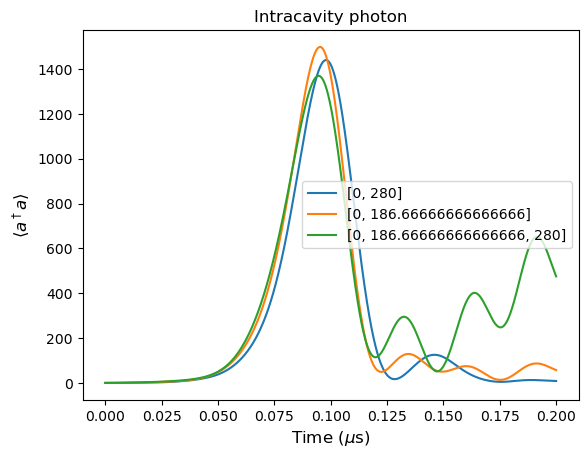

In [26]:
#############################################################
# Plots intracavity field
#############################################################
for i in [0,6,7]:
    end_ind = utils.cut_time(results[0][0], -1)
    print(end_ind)
    plt.plot(results[i][0], results[i][3], label=detunings[i])
plt.title("Intracavity photon", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle a^\dagger a\rangle$", fontsize=12)
plt.legend()

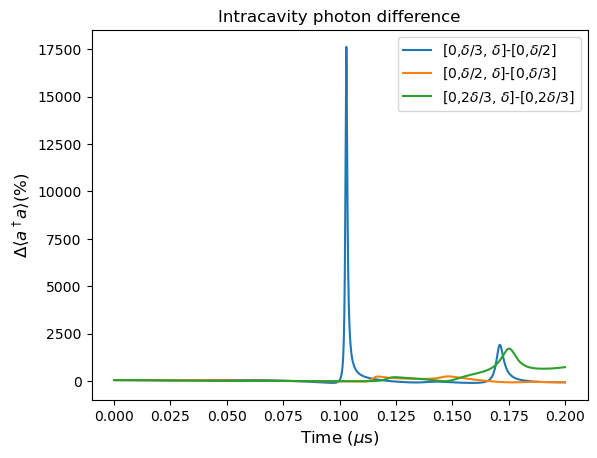

In [24]:
# More code on diff photons
ada_03 = (results[3][3]-results[1][3])/results[1][3]*100
ada_13 = (results[5][3]-results[4][3])/results[4][3]*100
ada_23 = (results[7][3]-results[6][3])/results[6][3]*100
plt.plot(results[0][0], ada_13, label=r"[0,$\delta/3$, $\delta$]-[0,$\delta/2$]")
plt.plot(results[0][0], ada_03, label=r"[0,$\delta/2$, $\delta$]-[0,$\delta/3$]")
plt.plot(results[0][0], ada_23, label=r"[0,$2\delta/3$, $\delta$]-[0,$2\delta/3$]")
plt.title("Intracavity photon difference", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\Delta\langle a^\dagger a\rangle (\%)$", fontsize=12)
plt.legend()

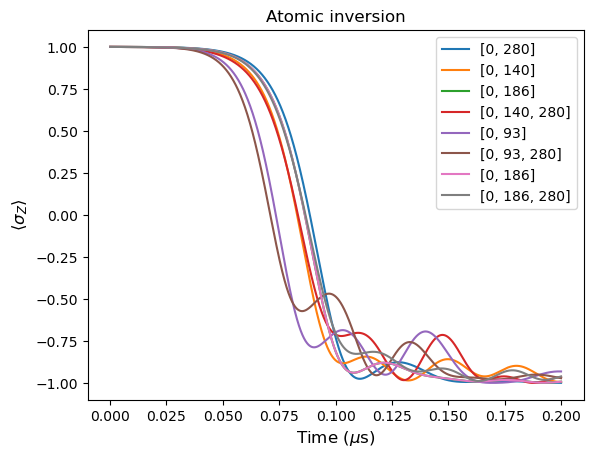

In [32]:
#############################################################
# Line plots for inversion and coherence
#############################################################
for i in range(len(detunings)):
    if len(detunings[i])<2:
        plt.plot(results[i][0], results[i][1], label=int(detunings[i]))
    else:
        plt.plot(results[i][0], results[i][1][:,0], label=[int(k) for k in detunings[i]])
# Td = utils.findTd(results[0][1], results[0][0])
# print(Td)
plt.title("Atomic inversion", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_Z \rangle$", fontsize=12)
plt.legend()

In [ ]:
plt.plot(results[0][0], results[0][2], label=detunings[0])
plt.title("Coherence", fontsize=12)
plt.xlabel(r"Time ($\mu$s)", fontsize=12)
plt.ylabel(r"$\langle \sigma_+\sigma_- \rangle$", fontsize=12)
plt.legend()

In [ ]:
utils.plot_heat(results[0],detuning_values_1d[:20], np.rot90(results[1]), -1.0,1.0, 
                "Atom inversion $\langle\sigma_Z\\rangle$", "Time ($\mu$s)", "Detuning (kHz)")

In [ ]:
utils.plot_heat(results[0],detuning_values_1d, np.rot90(results[2]), 0,0.25, 
                "Coherences", "Time ($\mu$s)", "$\langle\sigma_+\sigma_-\\rangle$")

In [ ]:

a = np.rot90(np.asarray([[0,1,2],[3,4,5]]))
print(a)
utils.plot_heat([0,1], [3,2,1], a, 0,6, "na", "na", "na")